In [1]:
import green_ai.utils
from green_ai.experimentation import torch_Experimentation
from green_ai.models import small_ConvModel
import green_ai.datasets
import sklearn.metrics
from green_ai.models import FusedModel
from green_ai.models import Model

from green_ai.models import ConvLayer

import torchvision

import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision import transforms

import pandas as pd
import numpy as np

import dill
from typing import List, Tuple, Dict, Any, Union, Optional

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

SEED = 282
np.random.seed(SEED)
torch.manual_seed(SEED)

# LOAD CIFAR-10 dataset

Files already downloaded and verified
Files already downloaded and verified


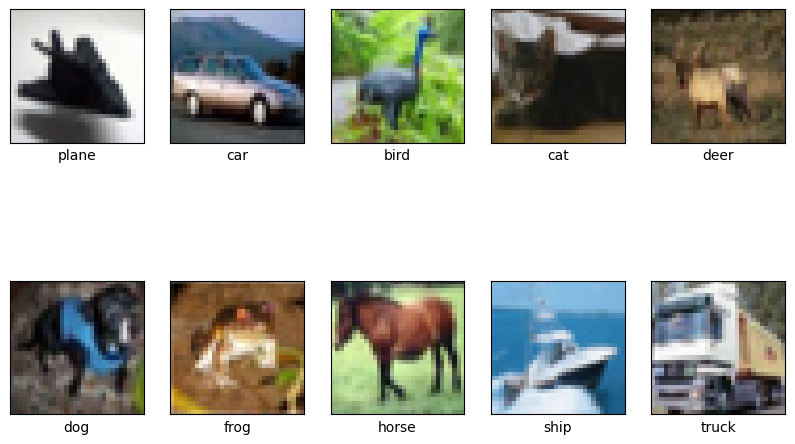

In [2]:
trainloader, testloader = green_ai.datasets.get_cifar10(
    path="../sandbox/data", batch_size=8
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

green_ai.datasets.plot_datasets_images(classes=classes, trainloader=trainloader)

### Définition des variables importantes

In [3]:
HEIGHT = trainloader.dataset.data.shape[1]
WIDTH = trainloader.dataset.data.shape[2]
IN_CHANNELS = trainloader.dataset.data.shape[3]
N_CLASSES = len(classes)
OUT_CHANNELS = 256
EPOCHS = 10

### Définition des modèles à comparer pour voir l'efficacité de la Separable Convolution

In [4]:
# define the model
model = green_ai.models.small_ConvModel(
    height=HEIGHT,
    width=WIDTH,
    in_channels=IN_CHANNELS,
    out_channels=OUT_CHANNELS,
    out_features=N_CLASSES,
    kernel_size=3,
)

separable_model = green_ai.models.small_ConvModel(
    height=HEIGHT,
    width=WIDTH,
    in_channels=IN_CHANNELS,
    out_channels=OUT_CHANNELS,
    out_features=N_CLASSES,
    kernel_size=3,
    separable=True,
)

separable_model_2depthwise = small_ConvModel(
    height=HEIGHT,
    width=WIDTH,
    in_channels=IN_CHANNELS,
    out_channels=OUT_CHANNELS,
    out_features=N_CLASSES,
    kernel_size=3,
    separable=True,
    depthwise_num=2,
)

### Loss & Optimizers

In [5]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

separable_optimizer = torch.optim.SGD(
    separable_model.parameters(), lr=0.001, momentum=0.9
)

separable_2depthwise_optimizer = torch.optim.SGD(
    separable_model_2depthwise.parameters(), lr=0.001, momentum=0.9
)

### Log (TODO : plus log en csv mais via mlflow)

In [6]:
log_file = "logs/image_data_sep.csv"
log_id = "conv_sep_2"

### Run notre experiment

In [7]:
try:

    experimentation_sep = dill.load(open("experiments/experiment_sepconv.pkl", "rb"))
    model, separable_model, separable_model_2depthwise = (
        experimentation_sep.get_models()
    )

except FileNotFoundError:

    experimentation_sep = torch_Experimentation(
        models=[model, separable_model, separable_model_2depthwise],
        optimizers=[optimizer, separable_optimizer, separable_2depthwise_optimizer],
        train_loader=trainloader,
        test_loader=testloader,
        metric_fn=sklearn.metrics.accuracy_score,
        loss_fn=criterion,
        log_file=log_file,
        log_id=log_id,
        model_names=["conv", "sep_conv", "sep_2depth_conv"],
        epochs=EPOCHS,
    )

    experimentation_sep.run_experiment(verbose=1)

    with open("experiments/experiment_sepconv.pkl", "wb") as f:
        dill.dump(experimentation_sep, f)

In [8]:
experimentation_sep.print_results()

             Model  Train Time (s)  Train Carbon (gCO2eq)  Test Loss  \
0             conv      200.589244               0.065054   0.811226   
1         sep_conv      177.635492               0.052473   0.964074   
2  sep_2depth_conv      182.424786               0.052895   0.834974   

   Test Metric  Inference Time (1000 samples)  Inference Carbon (gCO2eq)  
0       0.7379                       3.207690                   0.007979  
1       0.6730                       2.957044                   0.006119  
2       0.7208                       3.018845                   0.007785  


Model  Train Time (s)  Train Carbon (gCO2eq)  Test Loss  \
0             conv      200.589244               0.065054   0.811226   
1         sep_conv      177.635492               0.052473   0.964074   
2  sep_2depth_conv      182.424786               0.052895   0.834974   

   Test Metric  Inference Time (1000 samples)  Inference Carbon (gCO2eq)  
0       0.7379                       3.207690                   0.007979  
1       0.6730                       2.957044                   0.006119  
2       0.7208                       3.018845                   0.007785

In [9]:
experimentation_sep.get_model_sizes()

{'conv': 1.602422, 'sep_conv': 0.548731, 'sep_2depth_conv': 0.686588}

In [10]:
experimentation_sep.get_models_macs()

{'conv': 54151946, 'sep_conv': 7328130, 'sep_2depth_conv': 13454842}

In [11]:
from green_ai.models import torch_QATModel

try:

    experiment_qat = dill.load(open("experiments/experiment_conv_qat.pkl", "rb"))
    model, qat_model = experiment_qat.get_models()

except FileNotFoundError:
    qat_model = torch_QATModel(base_model=model)

    experiment_qat = torch_Experimentation(
        models=[model, qat_model],
        optimizers=[
            optimizer,
            torch.optim.SGD(qat_model.parameters(), lr=0.001, momentum=0.9),
        ],
        train_loader=trainloader,
        test_loader=testloader,
        metric_fn=sklearn.metrics.accuracy_score,
        loss_fn=criterion,
        log_file=log_file,
        log_id=log_id,
        model_names=["conv", "qat_conv"],
        epochs=EPOCHS,
        validation_set=True,
        validation_size=0.15,
        patience=3,
    )

    experiment_qat.run_experiment(verbose=1)

    with open("experiments/experiment_conv_qat.pkl", "wb") as f:
        dill.dump(experiment_qat, f)

In [12]:
experiment_qat.print_results()

      Model  Train Time (s)  Train Carbon (gCO2eq)  Test Loss  Test Metric  \
0      conv      178.555652               0.106405   0.814514       0.7275   
1  qat_conv      238.768798               0.143071   0.798420       0.7332   

   Inference Time (1000 samples)  Inference Carbon (gCO2eq)  
0                       3.454573                   0.019883  
1                       2.945426                   0.015292  


Model  Train Time (s)  Train Carbon (gCO2eq)  Test Loss  Test Metric  \
0      conv      178.555652               0.106405   0.814514       0.7275   
1  qat_conv      238.768798               0.143071   0.798420       0.7332   

   Inference Time (1000 samples)  Inference Carbon (gCO2eq)  
0                       3.454573                   0.019883  
1                       2.945426                   0.015292

In [13]:
print(green_ai.utils.get_model_size(qat_model))
print(green_ai.utils.get_model_size(model))

0.456311
1.622582


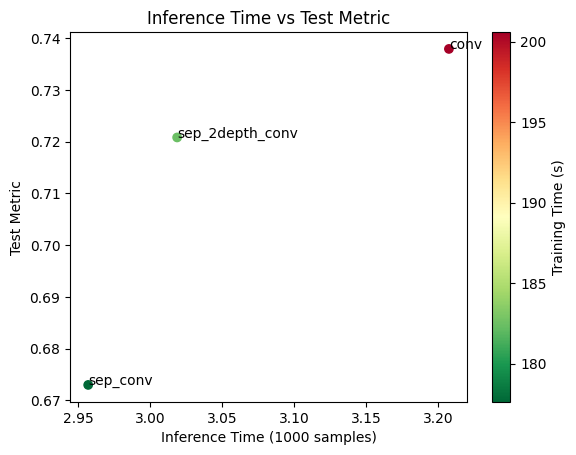

In [14]:
experimentation_sep.plot_inference_vs_score()

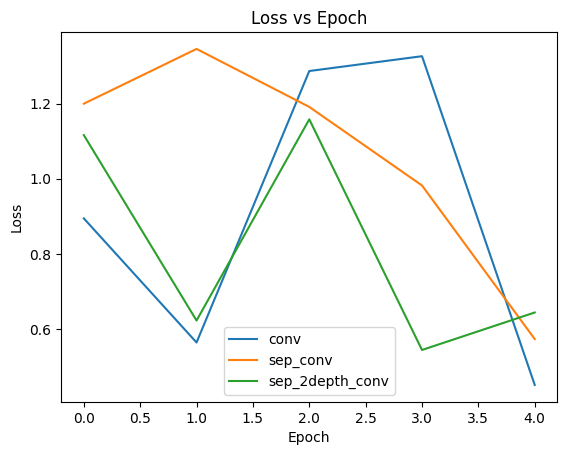

In [15]:
experimentation_sep.plot_loss()

In [16]:
model, separable_model, separable_model_2depthwise = experimentation_sep.get_models()

fused_model = FusedModel(model=model)
fused_model_sep = FusedModel(model=separable_model)
fused_model_sep_2depthwise = FusedModel(model=separable_model_2depthwise)

fused_optimizer = torch.optim.SGD(fused_model.parameters(), lr=0.001, momentum=0.9)
fused_optimizer_sep = torch.optim.SGD(
    fused_model_sep.parameters(), lr=0.001, momentum=0.9
)
fused_optimizer_sep_2depthwise = torch.optim.SGD(
    fused_model_sep_2depthwise.parameters(), lr=0.001, momentum=0.9
)

In [17]:
print(fused_model)

FusedModel(
  (model): small_ConvModel(
    (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc): Linear(in_features=9216, out_features=10, bias=True)
    (relu): ReLU(inplace=True)
    (output_func): Identity()
  )
)


In [18]:
log_file = "logs/image_data_fused.csv"
log_id = "fused_sepconv"

In [19]:
try:

    experimentation_sep_fused = dill.load(
        open("experiments/experiment_sep_fused.pkl", "rb")
    )

except FileNotFoundError:

    experimentation_sep_fused = torch_Experimentation(
        models=[fused_model, fused_model_sep, fused_model_sep_2depthwise],
        optimizers=[
            fused_optimizer,
            fused_optimizer_sep,
            fused_optimizer_sep_2depthwise,
        ],
        train_loader=trainloader,
        test_loader=testloader,
        metric_fn=sklearn.metrics.accuracy_score,
        loss_fn=criterion,
        log_file=log_file,
        log_id=log_id,
        model_names=["fused", "fused_sep", "fused_sep_2depth"],
        epochs=EPOCHS,
    )

    experimentation_sep_fused.run_experiment(verbose=1)

    with open("experiments/experiment_sep_fused.pkl", "wb") as f:
        dill.dump(experimentation_sep_fused, f)

In [20]:
experimentation_sep_fused.print_results()

              Model  Train Time (s)  Train Carbon (gCO2eq)  Test Loss  \
0             fused      200.589244               0.065054   0.811226   
1         fused_sep      177.635492               0.052473   0.964074   
2  fused_sep_2depth      182.424786               0.052895   0.834974   

   Test Metric  Inference Time (1000 samples)  Inference Carbon (gCO2eq)  
0       0.7379                       3.161677                   0.007514  
1       0.6730                       2.751588                   0.005847  
2       0.7208                       3.055737                   0.007510  


Model  Train Time (s)  Train Carbon (gCO2eq)  Test Loss  \
0             fused      200.589244               0.065054   0.811226   
1         fused_sep      177.635492               0.052473   0.964074   
2  fused_sep_2depth      182.424786               0.052895   0.834974   

   Test Metric  Inference Time (1000 samples)  Inference Carbon (gCO2eq)  
0       0.7379                       3.161677                   0.007514  
1       0.6730                       2.751588                   0.005847  
2       0.7208                       3.055737                   0.007510

In [21]:
print(experimentation_sep.get_models_macs())

print(experimentation_sep_fused.get_models_macs())

(54151946, 7328130, 13454842)
(53835018, 7011202, 13137914)


In [22]:
print(experimentation_sep.get_model_sizes())

print(experimentation_sep_fused.get_model_sizes())

(1.574294, 0.519738, 0.657594)
(1.566112, 0.511616, 0.649472)


In [ ]:
# approx. 40mn to run on cpu

out_chan = 256

sep = ConvLayer(separable=True, in_channels=IN_CHANNELS, out_channels=out_chan)
no_sep = ConvLayer(separable=False, in_channels=IN_CHANNELS, out_channels=out_chan)
fused_sep = ConvLayer(separable=True, in_channels=IN_CHANNELS, out_channels=out_chan)
fused_no_sep = ConvLayer(
    separable=False, in_channels=IN_CHANNELS, out_channels=out_chan
)

fused_sep.eval()
fused_no_sep.eval()

fused_sep.fuse_layers()
fused_no_sep.fuse_layers()

list = [sep, no_sep, fused_sep, fused_no_sep]
list_names = ["sep", "no_sep", "fused_sep", "fused_no_sep"]
times = []
carbons = []

for model in list:
    print("Timing ")
    time, carbon = green_ai.utils.time_torch(model=model, testloader=testloader)
    times.append(time)
    carbons.append(carbon)

In [ ]:
list_results = pd.DataFrame(
    {
        "model": list_names,
        "time": times,
        "carbon": carbons,
    }
)

print(list_results)

          model      time    carbon
0           sep  3.080054  0.006839
1        no_sep  4.625102  0.012367
2     fused_sep  2.898735  0.006294
3  fused_no_sep  4.353182  0.012610


# FINE-TUNING EXPERIMENT

In [24]:
sub_trainloader = green_ai.datasets.get_balanced_subset(
    data_loader=trainloader, num_classes=N_CLASSES, n_samples=2000
)

sub_testloader = green_ai.datasets.get_balanced_subset(
    data_loader=testloader, num_classes=N_CLASSES, n_samples=400
)

# verify balanced subset

print(green_ai.datasets.is_balanced(sub_trainloader))
print(green_ai.datasets.is_balanced(sub_testloader))

True
True


In [25]:
ft_model = Model(torchvision.models.resnet18(pretrained=True))

ft_model_scratch = Model(torchvision.models.resnet18(pretrained=False))

ft_model_last_layer = Model(torchvision.models.resnet18(pretrained=True))

for param in ft_model_last_layer.model.parameters():
    param.requires_grad = False

### Set their last layer to our actual feature number, this allow reset requires_grad to true for our 'last_layer' model

In [37]:
num_ftrs = ft_model_last_layer.model.fc.in_features
ft_model_last_layer.model.fc = torch.nn.Linear(num_ftrs, N_CLASSES)
ft_model.model.fc = torch.nn.Linear(num_ftrs, N_CLASSES)
ft_model_scratch.model.fc = torch.nn.Linear(num_ftrs, N_CLASSES)

In [38]:
ft_criterion = torch.nn.CrossEntropyLoss()

ft_optimizer = torch.optim.SGD(ft_model.parameters(), lr=0.001, momentum=0.9)
ft_optimizer_scratch = torch.optim.SGD(
    ft_model_scratch.parameters(), lr=0.001, momentum=0.9
)
ft_optimizer_last_layer = torch.optim.SGD(
    ft_model_last_layer.parameters(), lr=0.001, momentum=0.9
)

In [39]:
try:
    experimentation_ft = dill.load(open("experiments/experiment_ft_2.pkl", "rb"))
except FileNotFoundError:

    experimentation_ft = torch_Experimentation(
        models=[ft_model, ft_model_scratch, ft_model_last_layer],
        optimizers=[ft_optimizer, ft_optimizer_scratch, ft_optimizer_last_layer],
        train_loader=sub_trainloader,
        test_loader=sub_testloader,
        metric_fn=sklearn.metrics.accuracy_score,
        loss_fn=ft_criterion,
        log_file="logs/image_data_ft.csv",
        log_id="ft",
        model_names=["ft", "ft_scratch", "ft_last_layer"],
        epochs=EPOCHS * 2,
        validation_set=True,
        validation_size=0.15,
        patience=3,
    )

    experimentation_ft.run_experiment(verbose=2)

    with open("experiments/experiment_ft_2.pkl", "wb") as f:
        dill.dump(experimentation_ft, f)

Training models...
Training ft...


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via

[1, 531] loss: 2.067150413092022


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned

[1, 1062] loss: 1.6981847313164318


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via

[1, 1593] loss: 1.565140236961864


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: En

[1, 2124] loss: 1.4804274361798093


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned

[1, 2655] loss: 1.3983891927926553


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned

[1, 3186] loss: 1.357833781653205


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver

[1, 3717] loss: 1.2986795352228169


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via

[1, 4248] loss: 1.2483629089290813


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned

[1, 4779] loss: 1.2024227719185716


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: En

[1, 5310] loss: 1.2063939614316164


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


New best val loss: 0.12496129046976566
Epoch 1/20, Loss: 0.12496129046976566


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCom

[2, 531] loss: 1.1307967564480452


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample

[2, 1062] loss: 1.07979779655426


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a p

[2, 1593] loss: 1.0769280114416349


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCom

[2, 2124] loss: 1.0940113750947622


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample

[2, 2655] loss: 1.060587696324185


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: En

[2, 3186] loss: 1.0423861487212602


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample

[2, 3717] loss: 1.0678722934478195


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCom

[2, 4248] loss: 0.9916368875856004


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample

[2, 4779] loss: 0.9940341864545915


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCom

[2, 5310] loss: 0.9890236089009574


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


Epoch 2/20, Loss: 0.1375644673695167


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process whi

[3, 531] loss: 0.925307682341775


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process whi

[3, 1062] loss: 0.9115339444069763


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process whi

[3, 1593] loss: 0.9145559652966294


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: 

[3, 2124] loss: 0.8688013277765497


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver

[3, 2655] loss: 0.9116250400601583


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned

[3, 3186] loss: 0.886720385058676


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: 

[3, 3717] loss: 0.9104941218614354


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via

[3, 4248] loss: 0.8711207775774424


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe

[3, 4779] loss: 0.8704733985095598


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentia

[3, 5310] loss: 0.8432675702199199


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


New best val loss: 0.09356065006256103
Epoch 3/20, Loss: 0.09356065006256103


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[4, 531] loss: 0.7587309927309525


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[4, 1062] loss: 0.7540469537515425


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[4, 1593] loss: 0.7335080931668227


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[4, 2124] loss: 0.7716922505343028


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[4, 2655] loss: 0.815370702740724


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[4, 3186] loss: 0.7518483954578246


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[4, 3717] loss: 0.7363555425613164


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[4, 4248] loss: 0.7367166441263676


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[4, 4779] loss: 0.775423247177722


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[4, 5310] loss: 0.7950690577259172
New best val loss: 0.09017372259795665
Epoch 4/20, Loss: 0.09017372259795665


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[5, 531] loss: 0.6565382838698206


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: En

[5, 1062] loss: 0.7030924240376261


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[5, 1593] loss: 0.6523452329742258


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[5, 2124] loss: 0.6612545154399454


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[5, 2655] loss: 0.6964610655653499


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002b

[5, 3186] loss: 0.6698946309137367


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[5, 3717] loss: 0.7777030522849151


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[5, 4248] loss: 0.6793768108978503


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[5, 4779] loss: 0.693951785431126


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[5, 5310] loss: 0.7325382497926328


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


Epoch 5/20, Loss: 0.09510273421108723


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active 

[6, 531] loss: 0.5845922600414794


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCo

[6, 1062] loss: 0.619836456631705


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active 

[6, 1593] loss: 0.6131982961967728


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002b

[6, 2124] loss: 0.586584061510482


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active 

[6, 2655] loss: 0.5768822813283814


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: En

[6, 3186] loss: 0.6251268067314744


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: En

[6, 3717] loss: 0.6431427292574877


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: En

[6, 4248] loss: 0.6197786883796563


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCom

[6, 4779] loss: 0.6396235690054023


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCom

[6, 5310] loss: 0.6202768985788898


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample

Epoch 6/20, Loss: 0.11693178682823976


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[7, 531] loss: 0.5235039538610902


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[7, 1062] loss: 0.5415738797878141


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[7, 1593] loss: 0.5549652251658748


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[7, 2124] loss: 0.5454274595499375


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[7, 2655] loss: 0.553393041115191


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[7, 3186] loss: 0.5006228736101908


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[7, 3717] loss: 0.5232045207972412


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[7, 4248] loss: 0.5793835035930414


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[7, 4779] loss: 0.5222678263119217


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[7, 5310] loss: 0.5595848286022799


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


Early stopping
ft trained successfully
Training ft_scratch...


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[1, 531] loss: 2.223410385588917


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[1, 1062] loss: 1.9627163995008234


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[1, 1593] loss: 1.8810095100079554


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[1, 2124] loss: 1.7807471330107494


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[1, 2655] loss: 1.71866439212738


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[1, 3186] loss: 1.6934335731292625


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[1, 3717] loss: 1.5979289846905207


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[1, 4248] loss: 1.5765884573625755


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[1, 4779] loss: 1.5208845816538608


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[1, 5310] loss: 1.4922948875894206


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


New best val loss: 0.16776139234701792
Epoch 1/20, Loss: 0.16776139234701792


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[2, 531] loss: 1.4316752256646668


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[2, 1062] loss: 1.399058658917296


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[2, 1593] loss: 1.3864669789140955


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[2, 2124] loss: 1.3582279800582964


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[2, 2655] loss: 1.354871695380651


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[2, 3186] loss: 1.3537170174207167


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[2, 3717] loss: 1.296256404306929


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[2, 4248] loss: 1.2764550240363104


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[2, 4779] loss: 1.2545528450591417


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[2, 5310] loss: 1.23247305945039


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample

New best val loss: 0.14340710693597794
Epoch 2/20, Loss: 0.14340710693597794


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[3, 531] loss: 1.1856894053645053


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[3, 1062] loss: 1.149227678326788


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[3, 1593] loss: 1.1333424955774836


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[3, 2124] loss: 1.1357258388214866


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[3, 2655] loss: 1.1116894813019453


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[3, 3186] loss: 1.1079951240742498


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[3, 3717] loss: 1.131326146999097


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[3, 4248] loss: 1.0818447553168582


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[3, 4779] loss: 1.108275374983439


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[3, 5310] loss: 1.0574734027158967


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


New best val loss: 0.1290547366877397
Epoch 3/20, Loss: 0.1290547366877397


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCom

[4, 531] loss: 0.9893423327562275


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via

[4, 1062] loss: 0.976995057193124


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via

[4, 1593] loss: 0.9971077816802904


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned

[4, 2124] loss: 0.9681399144975928


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned

[4, 2655] loss: 0.9528046610945811


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: En

[4, 3186] loss: 0.9830785084747325


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver

[4, 3717] loss: 0.9502687364143166


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via

[4, 4248] loss: 0.94311022553628


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via

[4, 4779] loss: 0.931702122906058


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via

[4, 5310] loss: 0.9803499500293517


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample

New best val loss: 0.11882943341434002
Epoch 4/20, Loss: 0.11882943341434002


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[5, 531] loss: 0.8301564315281346


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[5, 1062] loss: 0.862640427022106


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[5, 1593] loss: 0.8464347738667396


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[5, 2124] loss: 0.8508954376206784


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[5, 2655] loss: 0.9100716732259974


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[5, 3186] loss: 0.8521533967916575


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[5, 3717] loss: 0.8260850785563221


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[5, 4248] loss: 0.8615782945337942


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[5, 4779] loss: 0.8529442178046861


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[5, 5310] loss: 0.836259046488787


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


New best val loss: 0.10792950541774432
Epoch 5/20, Loss: 0.10792950541774432


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCo

[6, 531] loss: 0.7739023811231225


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002b

[6, 1062] loss: 0.7262178852228122


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCo

[6, 1593] loss: 0.763814949509451


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a paral

[6, 2124] loss: 0.7830120411380536


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCo

[6, 2655] loss: 0.7794844409812193


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: E

[6, 3186] loss: 0.7605932560344201


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a 

[6, 3717] loss: 0.7829948898594258


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCo

[6, 4248] loss: 0.7673532465672762


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: E

[6, 4779] loss: 0.7721874000059121


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe

[6, 5310] loss: 0.7822235360769678


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


New best val loss: 0.10415279543648163
Epoch 6/20, Loss: 0.10415279543648163


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[7, 531] loss: 0.6226095263609441


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[7, 1062] loss: 0.6478108306697757


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[7, 1593] loss: 0.656981232055163


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[7, 2124] loss: 0.6786451648899727


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[7, 2655] loss: 0.6689468007289195


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[7, 3186] loss: 0.7042865313365073


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[7, 3717] loss: 0.7116922786680319


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[7, 4248] loss: 0.6593789984515943


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[7, 4779] loss: 0.6925068226434192


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[7, 5310] loss: 0.6710620595601768


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


Epoch 7/20, Loss: 0.10671291834885875


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[8, 531] loss: 0.5556040716580275


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[8, 1062] loss: 0.5810754749075056


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[8, 1593] loss: 0.5993923268749215


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[8, 2124] loss: 0.598153680110466


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[8, 2655] loss: 0.5816212645161848


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[8, 3186] loss: 0.600382945105686


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[8, 3717] loss: 0.6111349069957118


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[8, 4248] loss: 0.6043478686944801


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[8, 4779] loss: 0.6257631726661196


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[8, 5310] loss: 0.6490071125104041


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


Epoch 8/20, Loss: 0.10496085248788198


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[9, 531] loss: 0.5000349597798454


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[9, 1062] loss: 0.4896867355461567


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[9, 1593] loss: 0.5096977167462898


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[9, 2124] loss: 0.5095277602824675


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[9, 2655] loss: 0.5424283513774755


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[9, 3186] loss: 0.5527262885435686


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[9, 3717] loss: 0.5557078763407615


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[9, 4248] loss: 0.558074589944997


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[9, 4779] loss: 0.5625649370856429


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

[9, 5310] loss: 0.5593593930194186


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


Early stopping
ft_scratch trained successfully
Training ft_last_layer...


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[1, 531] loss: 2.1049052101968595
[1, 1062] loss: 2.013611906441367


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[1, 1593] loss: 1.9808937856706523
[1, 2124] loss: 2.0428632697592124
[1, 2655] loss: 1.980591626939576
[1, 3186] loss: 1.9990597001352328
[1, 3717] loss: 2.025744036204846


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[1, 4248] loss: 2.0112270006801225
[1, 4779] loss: 2.0354393251422658
[1, 5310] loss: 2.0155152088055726


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample

New best val loss: 0.28420372513930003
Epoch 1/20, Loss: 0.28420372513930003


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


[2, 531] loss: 2.029172477749108


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


[2, 1062] loss: 2.0644709232163296


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


[2, 1593] loss: 2.0077038691317743


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


[2, 2124] loss: 2.0199270089018366


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


[2, 2655] loss: 2.027484971475691


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


[2, 3186] loss: 2.06209778527531


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


[2, 3717] loss: 2.040548666497857


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


[2, 4248] loss: 2.0078140939471862
[2, 4779] loss: 1.9975628678857045


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


[2, 5310] loss: 2.0013039701402526


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


New best val loss: 0.25401532111167907
Epoch 2/20, Loss: 0.25401532111167907


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


[3, 531] loss: 2.0025755960613547


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


[3, 1062] loss: 1.9971786299667789


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


[3, 1593] loss: 2.010377741578384


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


[3, 2124] loss: 1.965238053021907


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


[3, 2655] loss: 2.0246326194869146


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


[3, 3186] loss: 2.0541928731564525


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


[3, 3717] loss: 2.0239328145980835


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


[3, 4248] loss: 2.008937711994078


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


[3, 4779] loss: 2.0457938140619496


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[3, 5310] loss: 2.0075488069187672


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


Epoch 3/20, Loss: 0.30193397498528163


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample

[4, 531] loss: 1.9960265459313904
[4, 1062] loss: 2.0042324164941934
[4, 1593] loss: 2.0074751941722218
[4, 2124] loss: 2.0418634304668046


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[4, 2655] loss: 2.0188034630315674
[4, 3186] loss: 2.0188928320582975
[4, 3717] loss: 1.9805550060029757


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[4, 4248] loss: 2.0189190022015975
[4, 4779] loss: 2.030523773977312


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[4, 5310] loss: 2.0137884913191284


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample

Epoch 4/20, Loss: 0.2684289791981379


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[5, 531] loss: 2.0263140834657487
[5, 1062] loss: 2.015240767356815
[5, 1593] loss: 1.981086644412434
[5, 2124] loss: 1.9873770264357946


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[5, 2655] loss: 2.002826711664541
[5, 3186] loss: 2.025225361637252
[5, 3717] loss: 1.9858504905314545


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


[5, 4248] loss: 2.02145180403625
[5, 4779] loss: 1.9952196270059057
[5, 5310] loss: 2.0430636331859957


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


Early stopping
ft_last_layer trained successfully
Testing models...
Testing ft...
ft tested successfully
Testing ft_scratch...
ft_scratch tested successfully
Testing ft_last_layer...


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


ft_last_layer tested successfully
Timing models...
Timing ft...


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


ft timed successfully
Timing ft_scratch...


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


ft_scratch timed successfully
Timing ft_last_layer...


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver

ft_last_layer timed successfully


In [40]:
experimentation_ft.print_results()

           Model  Train Time (s)  Train Carbon (gCO2eq)  Test Loss  \
0             ft      325.109823                    NaN   0.728473   
1     ft_scratch      435.188743                    NaN   0.855178   
2  ft_last_layer       40.856067               0.010139   2.032190   

   Test Metric  Inference Time (1000 samples)  Inference Carbon (gCO2eq)  
0      0.76250                       3.599710                   0.007285  
1      0.70675                       3.529955                   0.007367  
2      0.37725                       3.024635                   0.006725  


Model  Train Time (s)  Train Carbon (gCO2eq)  Test Loss  \
0             ft      325.109823                    NaN   0.728473   
1     ft_scratch      435.188743                    NaN   0.855178   
2  ft_last_layer       40.856067               0.010139   2.032190   

   Test Metric  Inference Time (1000 samples)  Inference Carbon (gCO2eq)  
0      0.76250                       3.599710                   0.007285  
1      0.70675                       3.529955                   0.007367  
2      0.37725                       3.024635                   0.006725

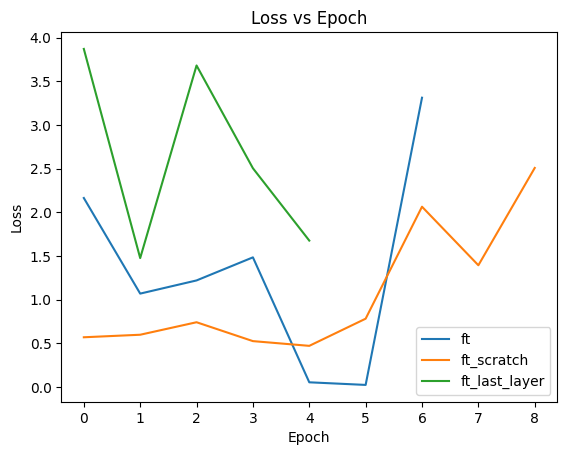

In [44]:
experimentation_ft.plot_loss()

In [41]:
import copy

student = green_ai.models.small_ConvModel(
    height=HEIGHT,
    width=WIDTH,
    in_channels=IN_CHANNELS,
    out_channels=OUT_CHANNELS // 8,
    out_features=N_CLASSES,
    kernel_size=3,
)

criterion = torch.nn.CrossEntropyLoss()

student_kd = green_ai.models.Student(
    teacher=model,
    student=copy.deepcopy(student),
    classification=True,
)

student_kd_optimizer = torch.optim.SGD(student_kd.parameters(), lr=0.001, momentum=0.9)

student_optimizer = torch.optim.SGD(student.parameters(), lr=0.001, momentum=0.9)

In [42]:
try:
    experimentation_student = dill.load(
        open("experiments/experiment_conv_kd.pkl", "rb")
    )

except FileNotFoundError:

    experimentation_student = torch_Experimentation(
        models=[student, student_kd],
        optimizers=[student_optimizer, student_kd_optimizer],
        train_loader=trainloader,
        test_loader=testloader,
        metric_fn=sklearn.metrics.accuracy_score,
        loss_fn=criterion,
        log_file="logs/image_data_student.csv",
        log_id="kd_cifar10",
        model_names=["student", "student_kd"],
        epochs=10,
        validation_set=True,
        validation_size=0.15,
        patience=3,
    )

    experimentation_student.run_experiment(verbose=1)

    with open("experiments/experiment_conv_kd.pkl", "wb") as f:
        dill.dump(experimentation_student, f)

In [43]:
experimentation_student.print_results()

        Model  Train Time (s)  Train Carbon (gCO2eq)  Test Loss  Test Metric  \
0     student       53.998414               0.016005   0.920916       0.6889   
1  student_kd      305.130689               0.148915   0.905181       0.6928   

   Inference Time (1000 samples)  Inference Carbon (gCO2eq)  
0                       2.635659                   0.007869  
1                       2.316266                   0.005849  


Model  Train Time (s)  Train Carbon (gCO2eq)  Test Loss  Test Metric  \
0     student       53.998414               0.016005   0.920916       0.6889   
1  student_kd      305.130689               0.148915   0.905181       0.6928   

   Inference Time (1000 samples)  Inference Carbon (gCO2eq)  
0                       2.635659                   0.007869  
1                       2.316266                   0.005849